<a href="https://colab.research.google.com/github/Plutobi/Former/blob/main/Image_Report_Assist_Model_1_5_4b_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/google/medgemma-1.5-4b-it

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/medgemma-1.5-4b-it)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="google/medgemma-1.5-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
pipe(text=messages)

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'input_text': [{'role': 'user',
    'content': [{'type': 'image',
      'url': 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG'},
     {'type': 'text', 'text': 'What animal is on the candy?'}]}],
  'generated_text': [{'role': 'user',
    'content': [{'type': 'image',
      'url': 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG'},
     {'type': 'text', 'text': 'What animal is on the candy?'}]},
   {'role': 'assistant',
    'content': 'The animal on the candy is a **bird**.\n'}]}]

In [ ]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("google/medgemma-1.5-4b-it")
model = AutoModelForImageTextToText.from_pretrained("google/medgemma-1.5-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
inputs = processor.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


The animal on the candy is a **bird**.
<end_of_turn>


Saving 101 2.jpg to 101 2 (1).jpg


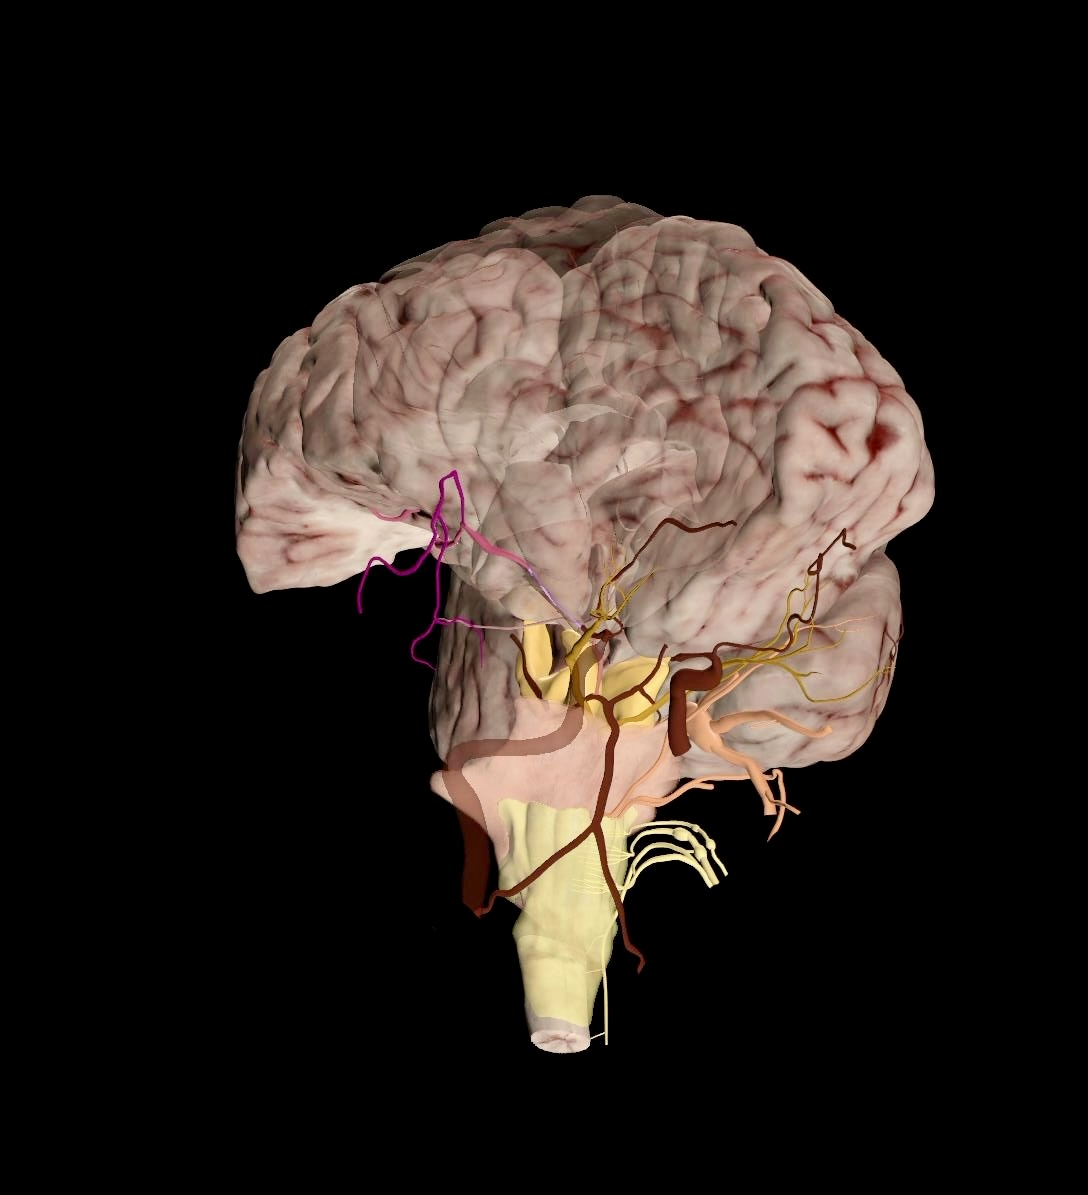

In [ ]:
from google.colab import files
from PIL import Image

uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
image = Image.open(image_filename)
image

In [ ]:
metadata = {
    "modality": "MRI",
    "anatomical_region": "Brain",
    "view": "Axial",
    "contrast": "Not specified"
}


In [ ]:
prompt = f"""
### Instruction:
You are a radiology documentation assistant powered by a medical language model.

Your task is to generate a structured, non-diagnostic imaging report draft based on study metadata.
Do NOT interpret image content.
Do NOT identify abnormalities or provide diagnoses.

### Imaging Study Metadata:
Modality: {metadata["modality"]}
Anatomical Region: {metadata["anatomical_region"]}
View: {metadata["view"]}
Contrast: {metadata["contrast"]}

### Required Output Format:
Study Type:
- Concise study name.

Views Included:
- Imaging views provided.

Structured Description:
- Brief, neutral description of the imaging study.

Notes:
- Include safety and clarification notes if applicable.

### Response:
"""


In [ ]:
messages_for_generation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": image_filename},
            {"type": "text", "text": prompt}
        ]
    },
]

inputs = processor.apply_chat_template(
    messages_for_generation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

outputs = model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.3,
    top_p=0.9,
    repetition_penalty=1.2,
    eos_token_id=processor.tokenizer.eos_token_id
)

generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]

result = processor.decode(
    generated_tokens,
    skip_special_tokens=True
)

print(result)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


FINDINGS: 3D reconstructed axial brain MRI with contrast was performed. The ventricles appear normal in size for age. No significant intracranial hemorrhage identified. There appears to be no evidence of acute infarcts.


In [ ]:
# Save the generated report to a text file
file_name = "report.txt"
with open(file_name, "w") as f:
    f.write(result)

print(f"Report saved to {file_name}")

Report saved to report.txt
